In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
import seaborn as sns
import os
# import glob
# import sys
import ast

# set inline print
%matplotlib inline

rootdir = os.path.join(".")
path_logs = os.path.join(rootdir,"learning_logs.csv")

def apfd(nqueries: list, hypsize: list):
    hs = hypsize
    nq = nqueries
    assert hs[0] == 1
    assert len(nq) == len(hs)
    return 1 - (np.sum(np.multiply(nq, np.diff([0, *hs]))) / (np.max(nq) * np.max(hs))) + (1.0 / (2 * np.max(nq)))

def derive_data(data_frame: pd.DataFrame.dtypes):
    # first, copy dataframe
    df = data_frame.copy()
    
    # ... and then split queries/symbols into different columns
    for qtype in ["Learning", "Testing"]:
        _lst= df[f"{qtype} queries/symbols"].apply(lambda x: [i.split('/') for i in ast.literal_eval(x)])
        df[f"{qtype} queries"]            = _lst.apply(lambda x : np.cumsum([int(i[0]) for i in x])) # resets
        df[f"{qtype} symbols"]            = _lst.apply(lambda x : np.cumsum([int(i[1]) for i in x])) # symbols w/o resets

    # ... and then parsing string with hypotheses sizes as array of integers
    df["HypSize"] = df["HypSize"].apply(lambda x: ast.literal_eval(x)) 

    # ... and then append qSize to HypSize, if the run is successfull 
    df["HypSize"] = df.apply(lambda x: x.HypSize + [x.Qsize] if x.Equivalent=='OK' and len(x.HypSize) < x.Rounds else x.HypSize, axis=1)
    
    # ... and then include #EQs from the single-state model
    df["Testing queries"] = df["Testing queries"].apply(lambda x: [0,*x])
    df["Testing symbols"] = df["Testing symbols"].apply(lambda x: [0,*x])
    
    # ... and then calculate the total number of queries
    df["Total queries"] = df.apply(lambda x: np.add(x["Testing queries"],x["Learning queries"]) if x.Equivalent=='OK' else [], axis=1)
    df["Total symbols"] = df.apply(lambda x: np.add(x["Testing symbols"],x["Learning symbols"]) if x.Equivalent=='OK' else [], axis=1)
    
    # ... and then (FINALLY!) calculate the APFD for MQs, EQs, and TQs
    df["APFD_test"] = df.apply(lambda x: apfd(x['Testing symbols'],x['HypSize']) if x.Equivalent=='OK' else -1, axis=1)
    df["APFD_total"] = df.apply(lambda x: apfd(x['Total symbols'],x['HypSize']) if x.Equivalent=='OK' else -1, axis=1)
    
    # to close, return the new dataframe with derived columns
    return df


# Split columns with queries/symbols

In [2]:
df = pd.read_csv(path_logs)
df = derive_data(df)

In [3]:
df.columns

Index(['Method', 'Seed', 'EquivalenceOracle', 'CTT', 'Extra States',
       'Random Infix Length', 'Cache', 'SUL name', 'Qsize', 'Isize',
       'TreeType', 'Learning queries/symbols', 'Testing queries/symbols',
       'HypSize', 'OTreeSize', 'MQ [Resets]', 'MQ [Symbols]', 'EQ [Resets]',
       'EQ [Symbols]', 'Rounds', 'Learning [ms]', 'Equivalent',
       'Learning queries', 'Learning symbols', 'Testing queries',
       'Testing symbols', 'Total queries', 'Total symbols', 'APFD_test',
       'APFD_total'],
      dtype='object')

In [4]:
# df_cols=['Method', 'CTT', 'Extra States', 'Random Infix Length', 'SUL name', 
# #          'Qsize', 'Rounds', \
# #          'Learning queries/symbols', 'Testing queries/symbols',\
#          'Learning symbols', 'Testing symbols', 'Total symbols', 'HypSize',\
#          'Equivalent', \
#          'APFD_test','APFD_total'
#         ]
# df.query('`Equivalent`=="OK"', engine="python")[df_cols]

In [5]:
# df.query('`Equivalent`=="OK"', engine="python")[['SUL name','Qsize']] \
#     .drop_duplicates(subset=['Qsize'],keep='last') \
#     .sort_values(by='Qsize')

In [6]:
sort_by=['SUL name', 'Method', 'APFD_test', 'APFD_total', 'CTT', 'Extra States']
bitwise=df.query('`Equivalent`=="OK" and `SUL name`=="BitVise.dot"').sort_values(by= sort_by)
bitwise[sort_by]

,SUL name,Method,APFD_test,APFD_total,CTT,Extra States
150,BitVise.dot,"L# (SepSeq, SepSeq)",0.708069,0.699950,HadsInt,1
246,BitVise.dot,"L# (SepSeq, SepSeq)",0.708435,0.700289,Hsi,1
21,BitVise.dot,"L# (SepSeq, SepSeq)",0.718362,0.717169,HadsInt,2
55,BitVise.dot,"L# (SepSeq, SepSeq)",0.718568,0.717375,Hsi,2
28,BitVise.dot,"L# (SepSeq, SepSeq)",0.802632,0.801911,Wp,2
44,BitVise.dot,"L# (SepSeq, SepSeq)",0.814376,0.813961,W,2
252,BitVise.dot,"L# (SepSeq, SepSeq)",0.834422,0.826770,Wp,1


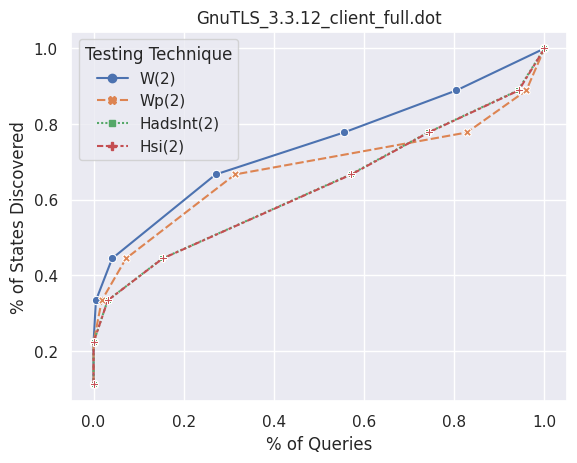

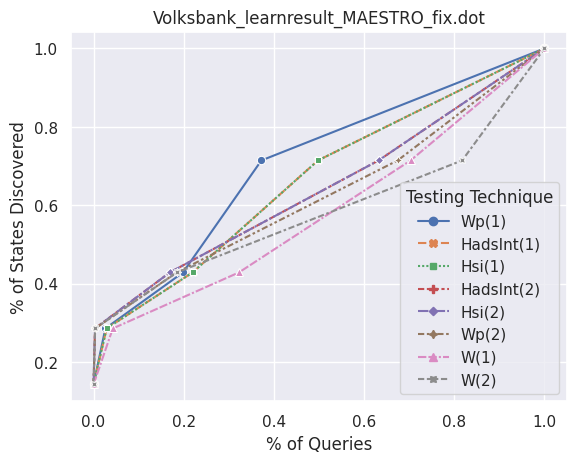

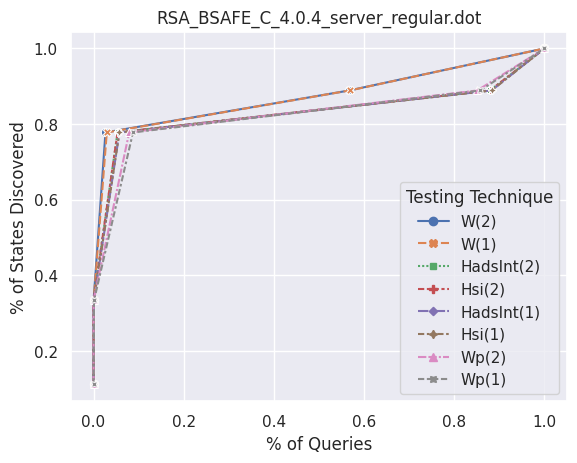

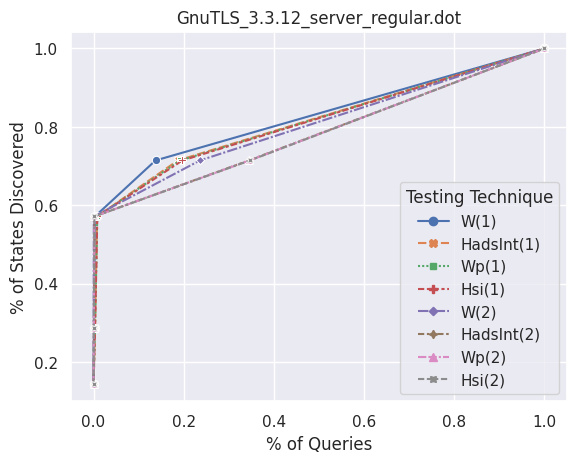

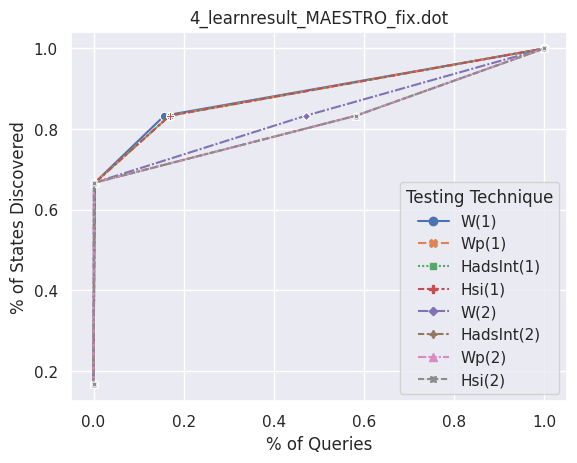

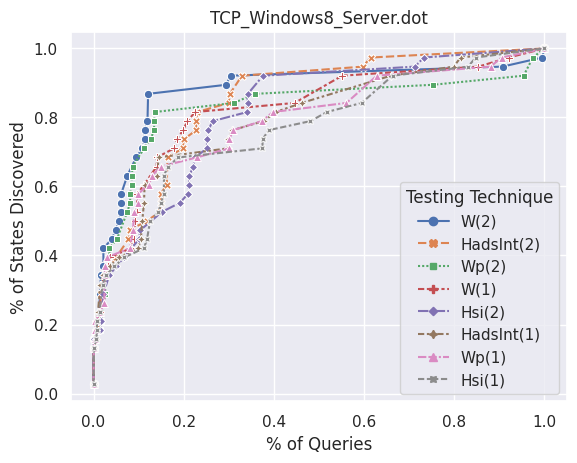

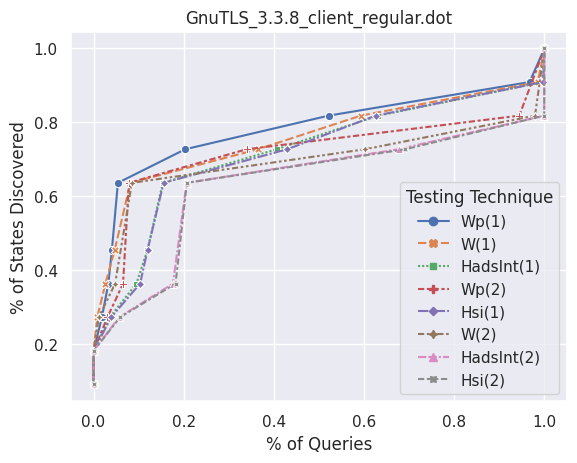

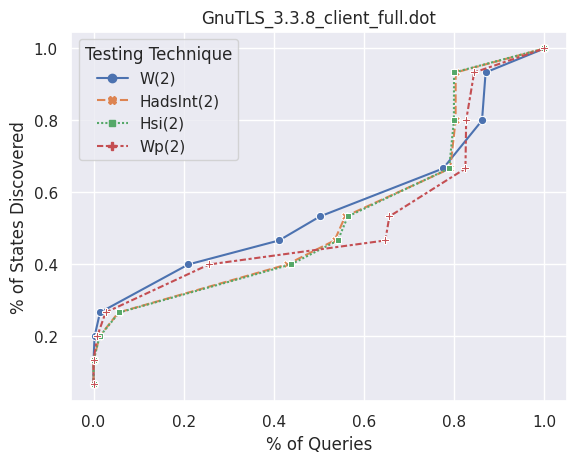

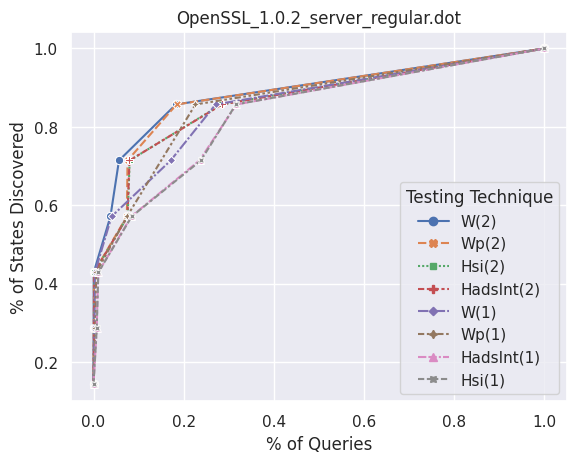

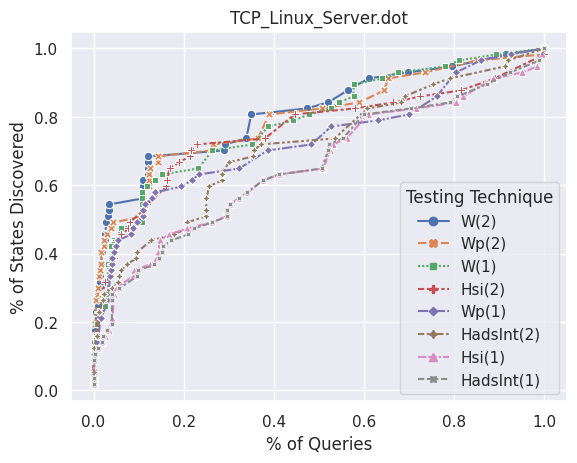

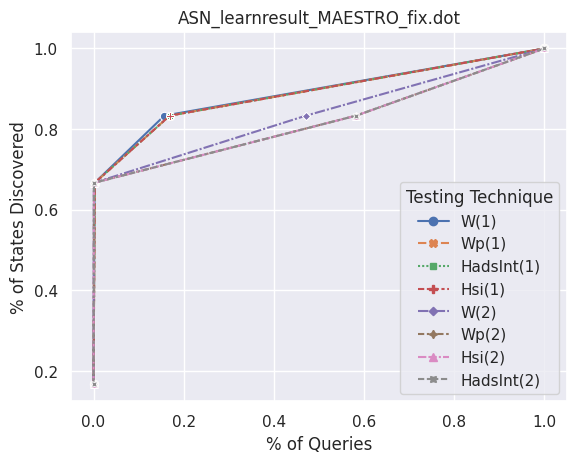

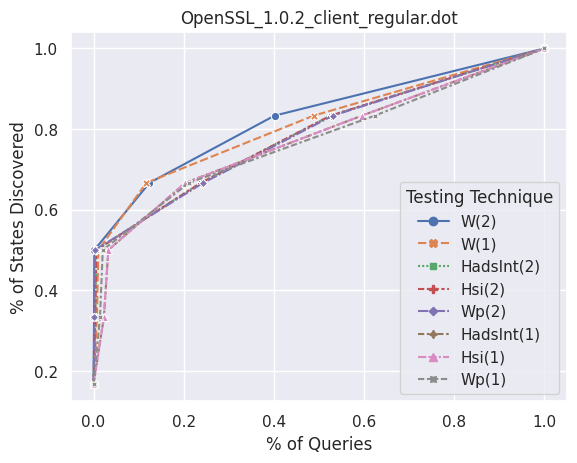

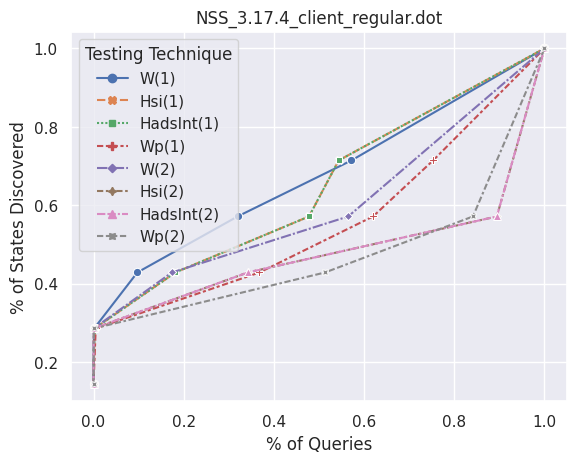

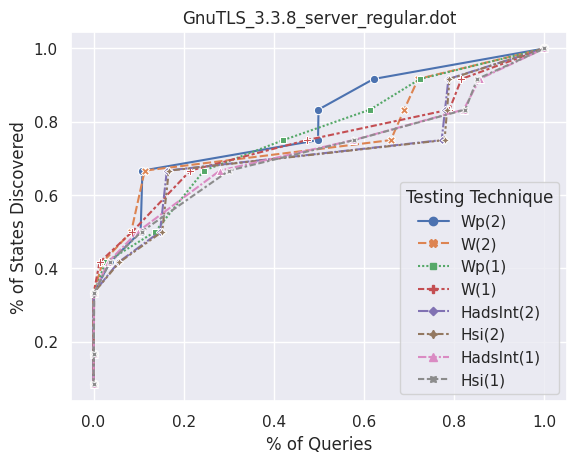

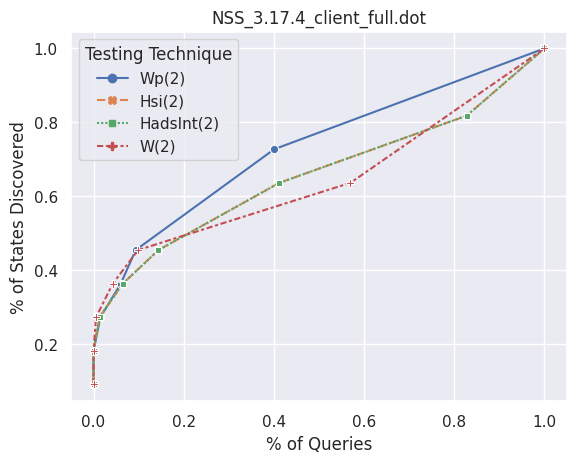

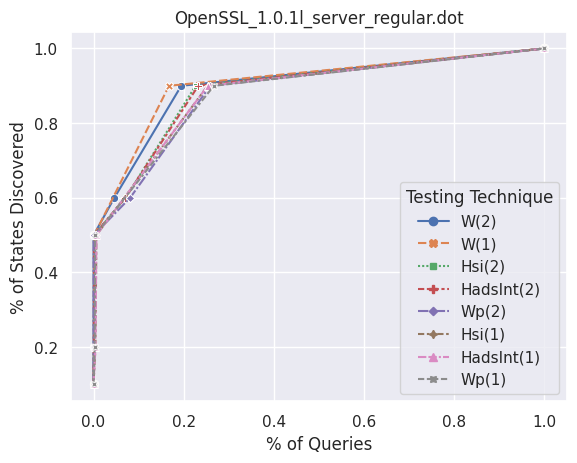

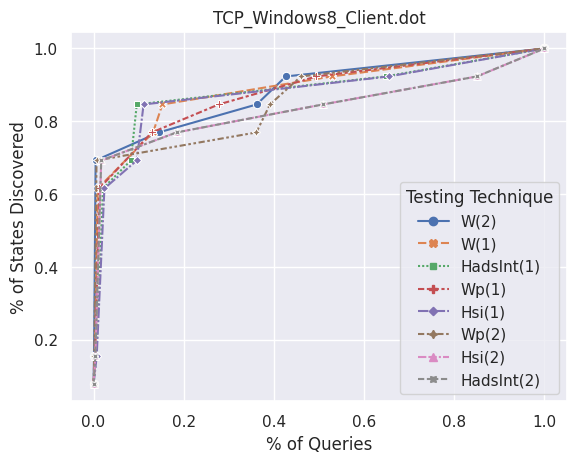

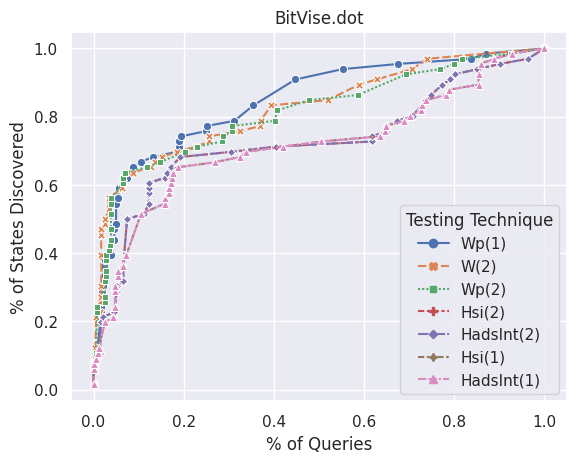

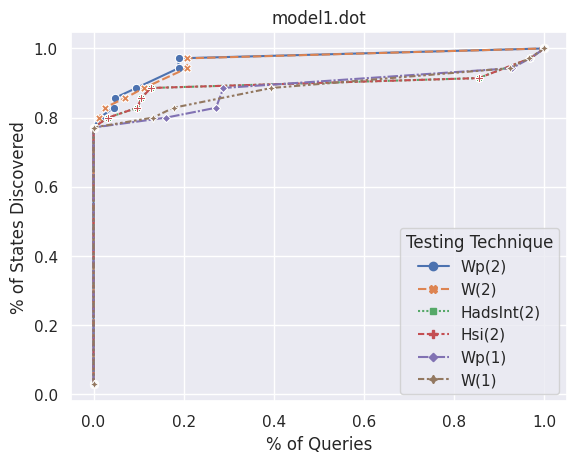

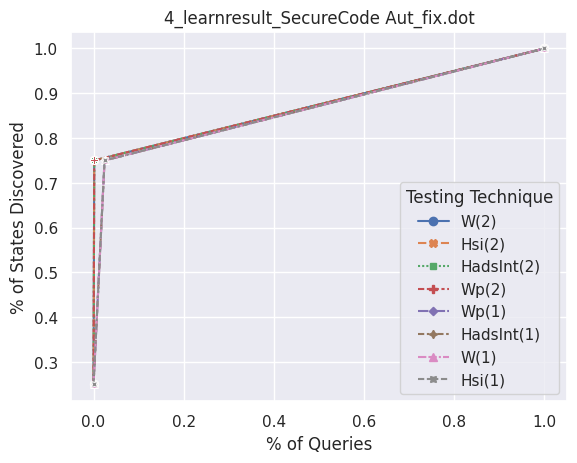

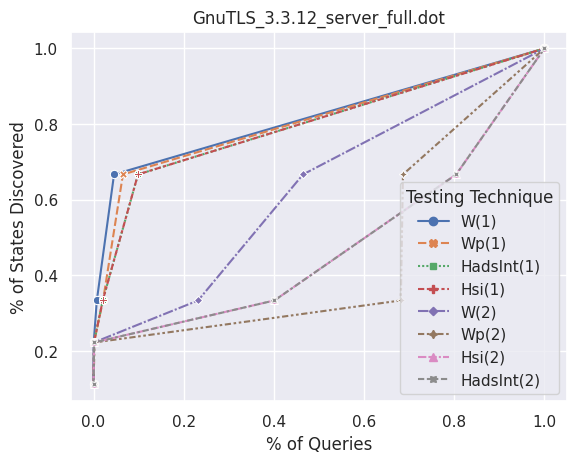

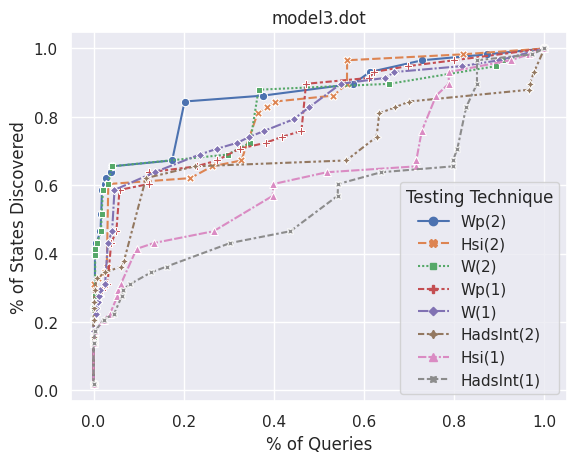

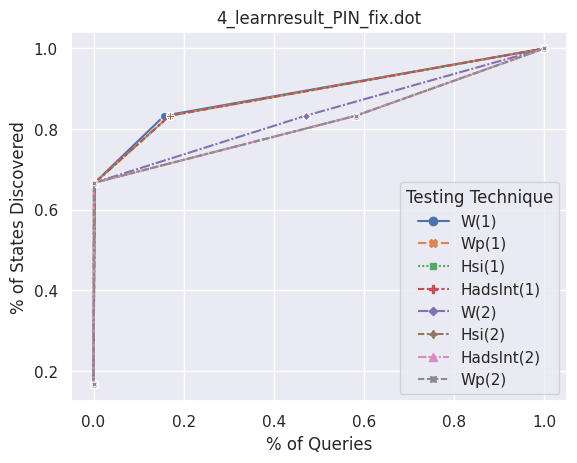

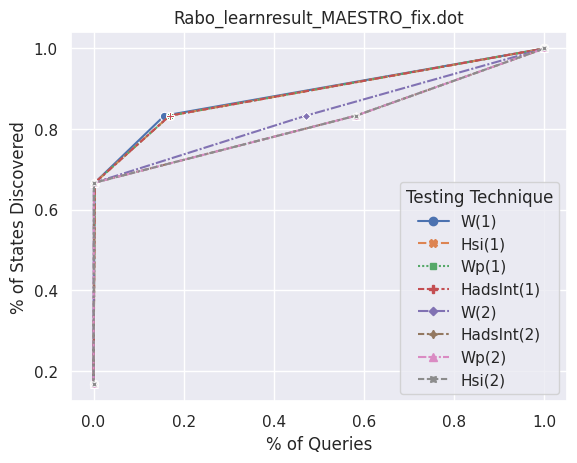

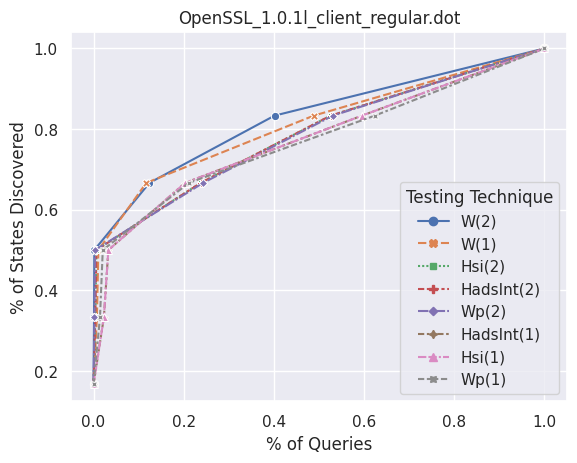

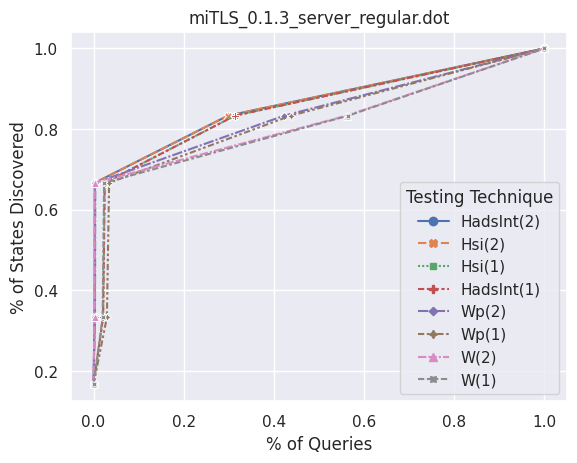

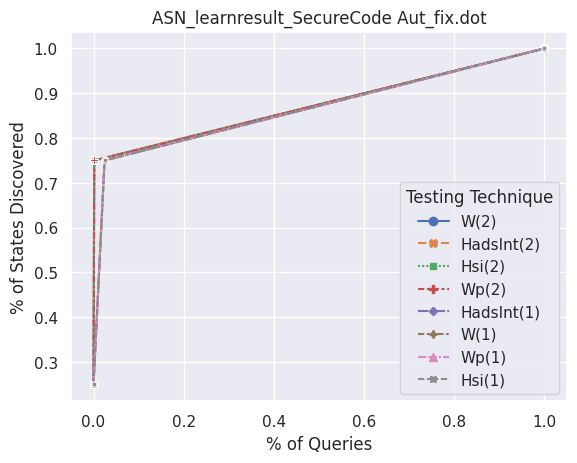

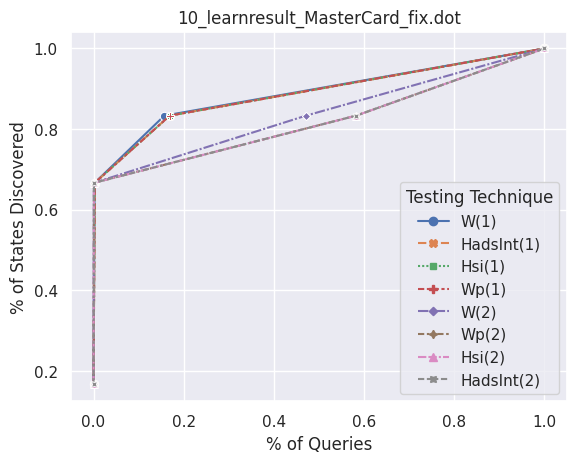

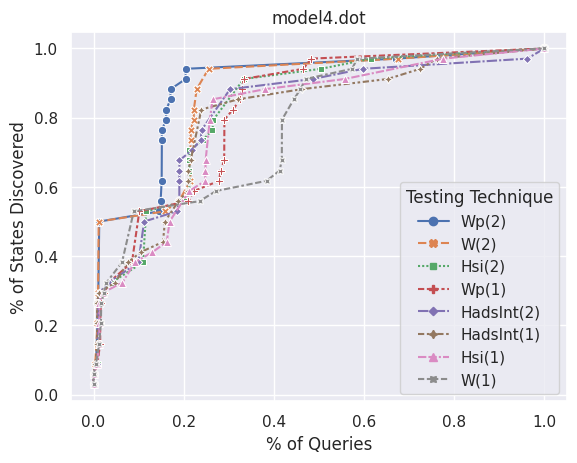

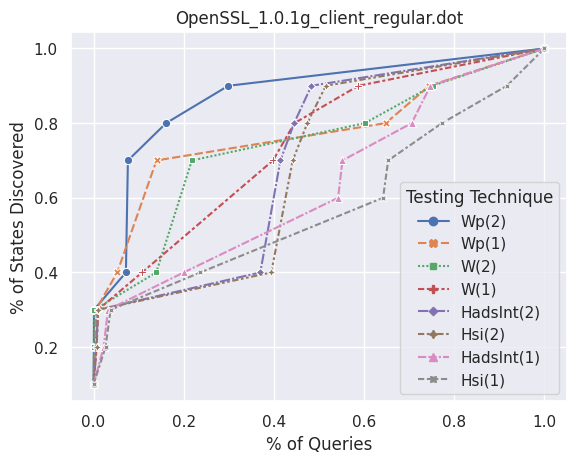

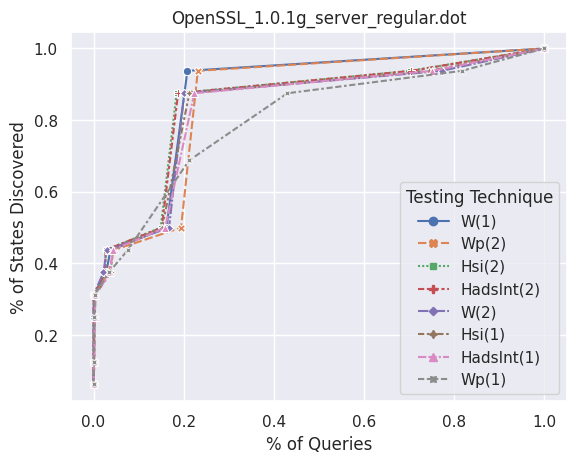

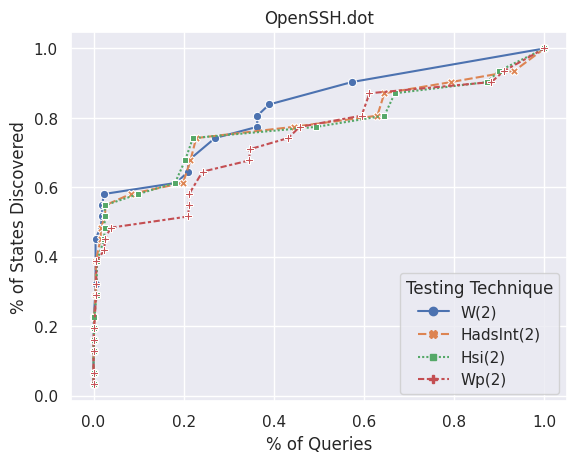

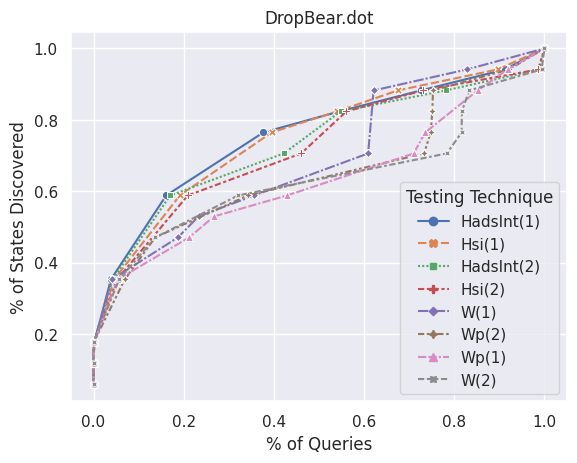

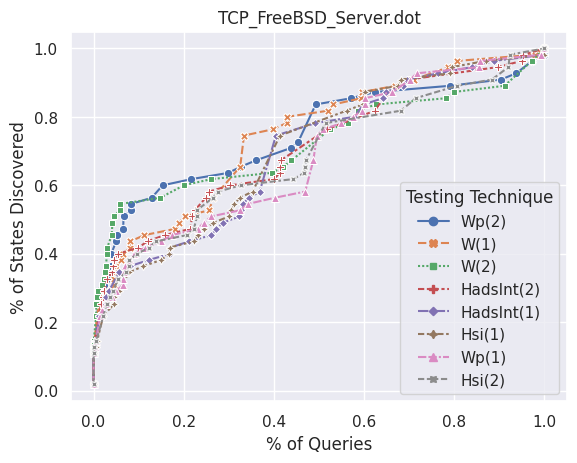

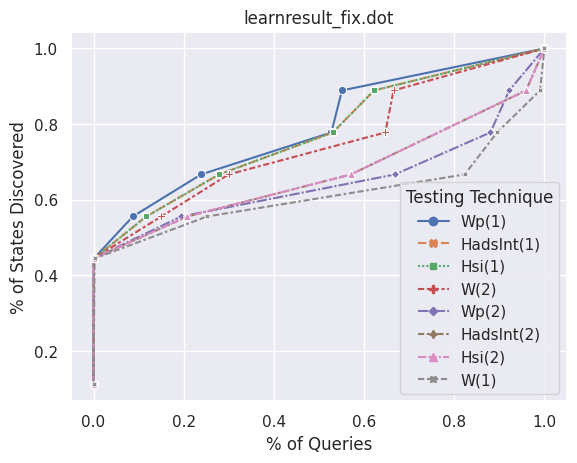

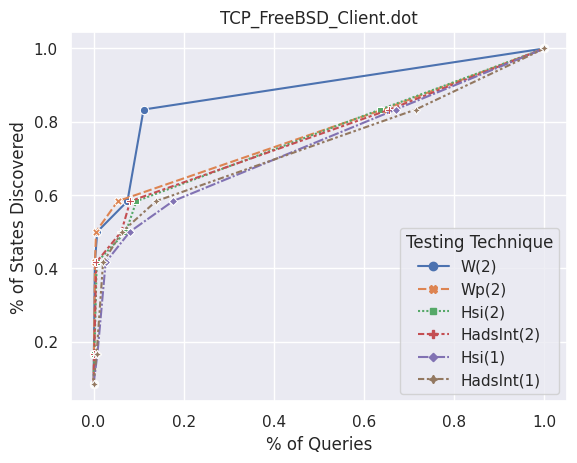

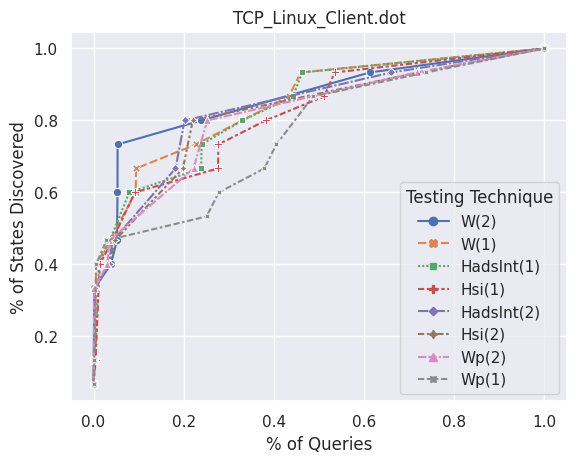

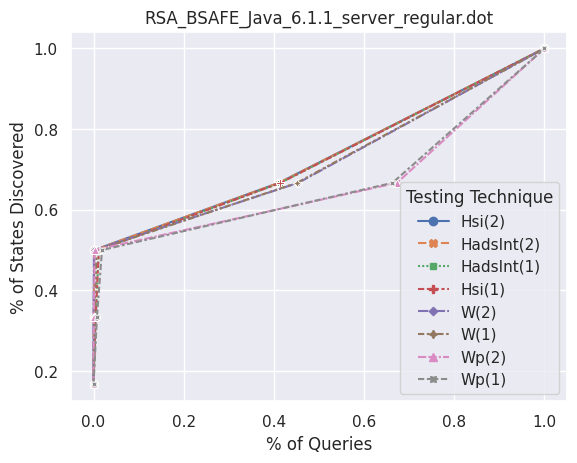

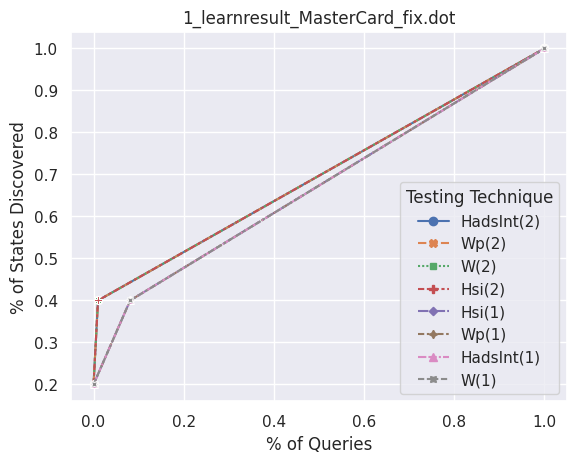

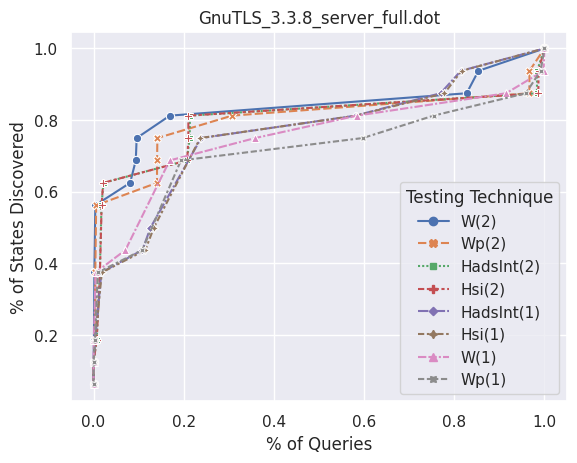

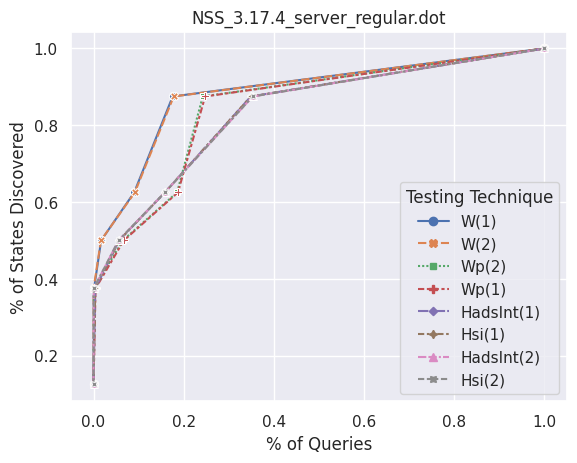

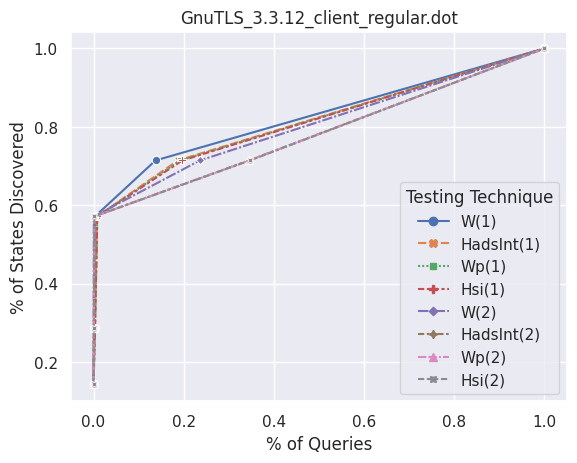

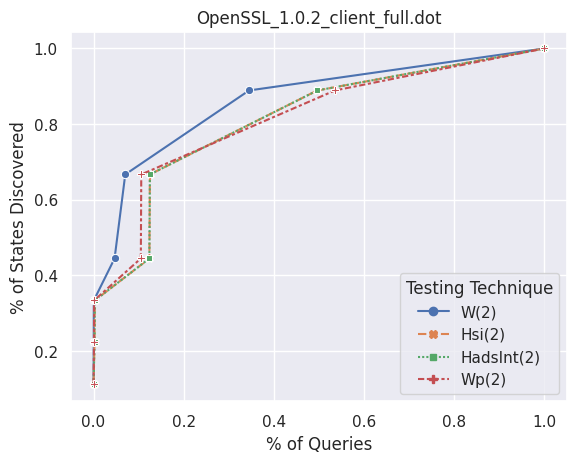

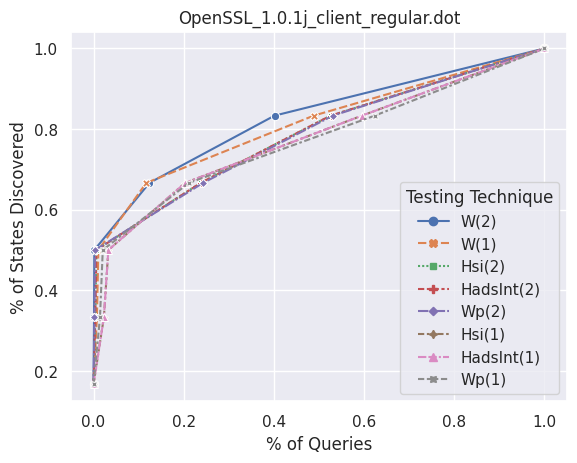

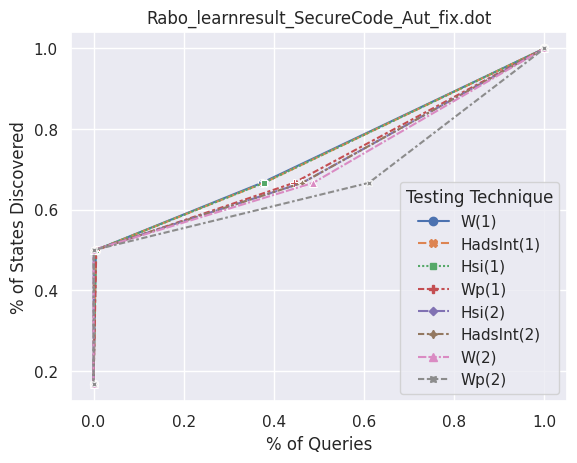

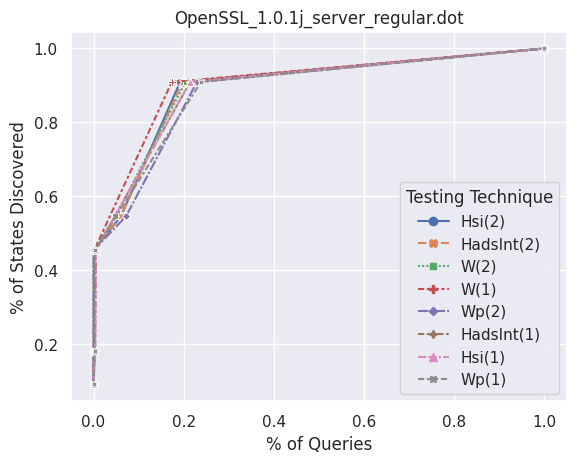

In [7]:
#set seaborn style
sns.set_theme()

for sul_name in df['SUL name'].drop_duplicates():
    # get one entry
    subj=df.query(f'`Equivalent`=="OK" and `SUL name`=="{sul_name}"').sort_values(by=['APFD_test'],ascending=False).copy()
    
    # add percent columns
    subj['HypSizePercent'] = subj['HypSize'].apply(lambda x: x/np.max(x))
    subj['TestingPercent'] = subj['Testing symbols'].apply(lambda x : x/np.max(x))
    subj['TotalPercent']   = subj['Total symbols'].apply(lambda x : x/np.max(x))
    subj['learningsetup']  = subj['CTT']+"("+subj['Extra States'].astype(str)+")"

    subj=subj.explode(['HypSizePercent','TestingPercent','TotalPercent'])

    #create area chart
    sns.lineplot(subj, x='TestingPercent', y='HypSizePercent',
                 markers=True, style='learningsetup', hue='learningsetup'
                )

    #add axis labels
    plt.xlabel('% of Queries')
    plt.ylabel('% of States Discovered')
    plt.legend(title='Testing Technique')
    plt.title(f'{sul_name}')

    #display area chart
    plt.show()